In [13]:
import os
# Display current working directory
print(os.getcwd())
# To make sure opencv imports .exr files
os.environ["OPENCV_IO_ENABLE_OPENEXR"] = "1"
# If the current directory is not WDSS, then set it to one level up
if os.getcwd()[-4:] != 'WDSS':
    os.chdir('..')
print(os.getcwd())

c:\Dev\MinorProject\WDSS
c:\Dev\MinorProject\WDSS


In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time

from typing import List, Tuple, Dict

from config import device, Settings
from commons import initialize

In [15]:
settings = Settings("config/config.json", "WDSSV5")
initialize(settings=settings)

Job: V5_Initial, Model: WDSSV5, Device: cuda


In [16]:
from network.dataset import *

train_dataset, val_dataset, test_dataset = WDSSDatasetCompressed.get_datasets(settings)

In [17]:
raw_frames = train_dataset._get_raw_frames(0)

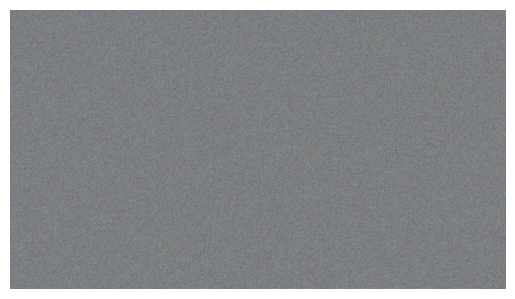

In [18]:
from network.modules import *

class WDSSModelV5(nn.Module):
    def __init__(self):
        super(WDSSModelV5, self).__init__()

        self.lr_frame_feature_extractor = LRFrameFeatureExtractor(12, 64, [32, 48, 48])
        self.hr_gbuffer_feature_extractor = HRGBufferFeatureExtractor(44, 5, 64)
        self.feature_fusion = FeatureFusion(64, 12, [64, 48])
        self.inr = FourierMappedINR(lr_feat_c=32, gb_feat_c=32, out_channels=12, mlp_inp_channels=64, hidden_channels=[64, 64, 64])

        self.final_conv = nn.Conv2d(12, 12, 3, 1, 1)

    def forward(self, lr_frame: torch.Tensor, hr_gbuffer: torch.Tensor, temporal: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        # Pixel unshuffling
        lr_frame_pixel_unshuffled = F.pixel_unshuffle(lr_frame, 2)
        hr_gbuffers_pixel_unshuffled = F.pixel_unshuffle(hr_gbuffer, 2)

        # Extract features
        lr_frame_feature = self.lr_frame_feature_extractor(lr_frame_pixel_unshuffled)
        hr_gbuffer_feature = self.hr_gbuffer_feature_extractor(hr_gbuffers_pixel_unshuffled)

        # Split the lr_frame_feature and hr_gbuffer_feature into 2-2 parts
        lr_frame_ff, lr_frame_inr = torch.split(lr_frame_feature, 32, dim=1)
        hr_gbuffer_ff, hr_gbuffer_inr = torch.split(hr_gbuffer_feature, 32, dim=1)

        # Upsample the lr_frame_ff
        lr_frame_ff = ImageUtils.upsample(lr_frame_ff, 2)

        # Feature Fusion, input is concatenated lr_frame_ff and hr_gbuffer_ff
        feature_fusion = self.feature_fusion(torch.cat([lr_frame_ff, hr_gbuffer_ff], dim=1))

        # INR
        inr = self.inr(lr_frame_inr, hr_gbuffer_inr)

        # Element-wise addition
        out = feature_fusion + inr

        # Final Convolution
        out = self.final_conv(out)

        return out, WaveletProcessor.batch_iwt(out)
    
# Model
model = WDSSModelV5().to(device)

# Run a forward pass to res
model.eval()
with torch.no_grad():
    test_data = test_dataset[1]
    lr_frame = test_data['LR'].unsqueeze(0).to(device)
    hr_gbuffer = test_data['GB'].unsqueeze(0).to(device)
    # temporal = test_data['TEMPORAL'].unsqueeze(0).to(device)

    wavelets, res = model(lr_frame, hr_gbuffer, None)

    ImageUtils.display_image(res.detach().cpu())

In [19]:
from network.losses import CriterionMSE

criterion = CriterionMSE()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [20]:
from network.trainer import Trainer

trainer = Trainer(settings, model, optimizer, criterion, train_dataset, val_dataset)

In [21]:
trainer.load_best_checkpoint()
print(trainer.total_epochs)
trainer.total_epochs = 10

16


In [ ]:
trainer.train(num_epochs=10)